In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from fastai.tabular.core import Categorify,TabularPandas
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from kerastuner import RandomSearch, HyperParameters,BayesianOptimization

<ipython-input-2-6b1b41eb39eb>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch, HyperParameters,BayesianOptimization


In [ ]:
injury_df = pd.read_csv('/content/drive/MyDrive/AD799 Final/InjuryRecord.csv')
play_df = pd.read_csv('/content/drive/MyDrive/AD799 Final/PlayList.csv')
#player_track_df = pd.read_csv('/content/drive/MyDrive/AD799 Final/PlayerTrackData.csv')

In [ ]:
player_track_df = pd.read_csv('/content/drive/MyDrive/AD799 Final/PlayerTrackData.csv')

In [ ]:
player_track_df.head()

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09


In [ ]:
play_df.Temperature.value_counts()

-999    24170
 68     14127
 72      6970
 61      6744
 71      6261
        ...  
 34       418
 32       383
 10       292
 26       243
 9        210
Name: Temperature, Length: 79, dtype: int64

In [ ]:
play_df.isna().sum()

PlayerKey             0
GameID                0
PlayKey               0
RosterPosition        0
PlayerDay             0
PlayerGame            0
StadiumType       16910
FieldType             0
Temperature           0
Weather           18691
PlayType            367
PlayerGamePlay        0
Position              0
PositionGroup         0
dtype: int64

In [ ]:
player_track_df.isna().sum()

In [ ]:
injury_df.isna().sum()

In [ ]:
target_df = play_df[['PlayerKey','PlayKey','StadiumType', 'FieldType', 'Weather', 'PlayType', 'PositionGroup', ]]

In [ ]:
target_df

,PlayerKey,PlayKey,StadiumType,FieldType,Weather,PlayType,PositionGroup
0,26624,26624-1-1,Outdoor,Synthetic,Clear and warm,Pass,QB
1,26624,26624-1-2,Outdoor,Synthetic,Clear and warm,Pass,QB
2,26624,26624-1-3,Outdoor,Synthetic,Clear and warm,Rush,QB
3,26624,26624-1-4,Outdoor,Synthetic,Clear and warm,Rush,QB
4,26624,26624-1-5,Outdoor,Synthetic,Clear and warm,Pass,QB
...,...,...,...,...,...,...,...
267000,47888,47888-13-51,Outdoor,Synthetic,Sunny and cold,Pass,DB
267001,47888,47888-13-52,Outdoor,Synthetic,Sunny and cold,Pass,DB
267002,47888,47888-13-53,Outdoor,Synthetic,Sunny and cold,Pass,DB
267003,47888,47888-13-54,Outdoor,Synthetic,Sunny and cold,Pass,DB


In [ ]:
play_group = player_track_df.groupby('PlayKey')
speed = play_group.s.mean().reset_index()
dis = play_group.dis.sum().reset_index()
time = play_group.time.max().reset_index()
target_df = target_df.merge(dis, how = 'left', on = 'PlayKey')
target_df = target_df.merge(time, how = 'left', on = 'PlayKey') # using left join because there are mismatch of play between target_df and Player_track_df

In [ ]:
target_df['s'] = target_df['dis']/target_df['time']

In [ ]:
target_df.isna().sum()

PlayerKey            0
PlayKey              0
StadiumType      16910
FieldType            0
Weather          18691
PlayType           367
PositionGroup        0
dis                 45
time                45
s                   45
dtype: int64

In [ ]:
target_df

,PlayerKey,PlayKey,StadiumType,FieldType,Weather,PlayType,PositionGroup,dis,time,s
0,26624,26624-1-1,Outdoor,Synthetic,Clear and warm,Pass,QB,16.83,29.8,0.564765
1,26624,26624-1-2,Outdoor,Synthetic,Clear and warm,Pass,QB,23.42,25.9,0.904247
2,26624,26624-1-3,Outdoor,Synthetic,Clear and warm,Rush,QB,10.68,29.5,0.362034
3,26624,26624-1-4,Outdoor,Synthetic,Clear and warm,Rush,QB,6.86,12.6,0.544444
4,26624,26624-1-5,Outdoor,Synthetic,Clear and warm,Pass,QB,25.94,25.9,1.001544
...,...,...,...,...,...,...,...,...,...,...
267000,47888,47888-13-51,Outdoor,Synthetic,Sunny and cold,Pass,DB,46.22,37.0,1.249189
267001,47888,47888-13-52,Outdoor,Synthetic,Sunny and cold,Pass,DB,53.33,29.4,1.813946
267002,47888,47888-13-53,Outdoor,Synthetic,Sunny and cold,Pass,DB,34.29,18.7,1.833690
267003,47888,47888-13-54,Outdoor,Synthetic,Sunny and cold,Pass,DB,77.07,35.7,2.158824


In [ ]:
cat_names = ['StadiumType', 'FieldType', 'Weather','PlayType', 'PositionGroup']
procs = [Categorify]
tabular_data = TabularPandas(target_df, procs, cat_names)
target_df = tabular_data.items

In [ ]:
label_data = pd.DataFrame({'PlayerKey':target_df.PlayerKey.unique().tolist(),
                          'Label':pd.Series([np.nan] * 250)})

In [ ]:
for player in label_data.PlayerKey:
    if player in injury_df.PlayerKey.tolist():
        feature = label_data.PlayerKey == player
        label_data.loc[feature,'Label'] = 1

In [ ]:
label_data['Label'].fillna(value=0, inplace=True)
label_data['Label'] = label_data['Label'].astype(int)

In [ ]:
len(label_data)

250

In [ ]:
sum(label_data.PlayerKey == target_df.PlayerKey.unique()) # checking the relationship between label_df  and target_df

250

In [ ]:
def standardize(df, column_names):
    for column_name in column_names:
        mean = df[column_name].mean()
        std_dev = df[column_name].std()
        df[column_name] = (df[column_name] - mean) / std_dev
    return df

In [ ]:
norm_target_df = standardize(target_df,['s','dis','time'])

In [ ]:
norm_target_df.isna().sum()

PlayerKey         0
PlayKey           0
StadiumType       0
FieldType         0
Weather           0
PlayType          0
PositionGroup     0
dis              45
time             45
s                45
dtype: int64

In [ ]:
norm_target_df = norm_target_df.fillna(0)

In [ ]:
norm_target_df = pd.merge(norm_target_df,label_data, how = 'left')

In [ ]:
norm_target_df

,PlayerKey,PlayKey,StadiumType,FieldType,Weather,PlayType,PositionGroup,dis,time,s,Label
0,26624,26624-1-1,19,2,9,7,6,-0.977832,0.102548,-1.116109,0
1,26624,26624-1-2,19,2,9,7,6,-0.673555,-0.219426,-0.652143,0
2,26624,26624-1-3,19,2,9,11,6,-1.261793,0.077781,-1.393179,0
3,26624,26624-1-4,19,2,9,11,6,-1.438172,-1.317439,-1.143881,0
4,26624,26624-1-5,19,2,9,7,6,-0.557200,-0.219426,-0.519168,0
...,...,...,...,...,...,...,...,...,...,...,...
267000,47888,47888-13-51,19,2,59,7,1,0.379179,0.696962,-0.180715,0
267001,47888,47888-13-52,19,2,59,7,1,0.707466,0.069525,0.591132,0
267002,47888,47888-13-53,19,2,59,7,1,-0.171659,-0.813839,0.618116,0
267003,47888,47888-13-54,19,2,59,7,1,1.803602,0.589637,1.062472,0


In [ ]:
norm_target_df.Label.value_counts()

0    177256
1     89749
Name: Label, dtype: int64

In [ ]:
len(norm_target_df)

267005

(array([28., 36., 26., 27., 31., 25., 26., 28., 14.,  9.]),
 array([  24. ,  263.8,  503.6,  743.4,  983.2, 1223. , 1462.8, 1702.6,
        1942.4, 2182.2, 2422. ]),
 <BarContainer object of 10 artists>)

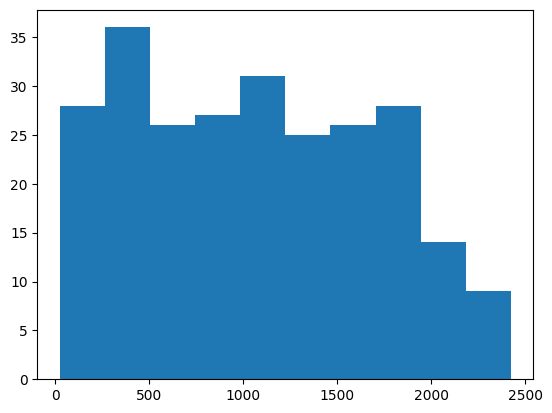

In [ ]:
plt.hist(norm_target_df.PlayerKey.value_counts()) # numbers of play is different for each player

In [ ]:
norm_target_df.PlayerKey.value_counts().max() # the maximum number play of a player is 2422

2422

# Padding

In [ ]:
target_group = norm_target_df.groupby('PlayerKey')
player_dataframes = {}
target_row_count = 2422  # Set the target row count/ timestep

for name, group in target_group:
    # Reset the index of the group DataFrame
    group = group.reset_index(drop=True)

    if len(group) > target_row_count:
        group = group[:target_row_count]
    elif len(group) < target_row_count:
        # Calculate the number of rows needed to reach the target row count
        missing_rows = target_row_count - len(group)
        # Create a DataFrame with the missing_rows count, filled with 0
        fill_df = pd.DataFrame(0, index=range(missing_rows), columns=group.columns)
        fill_df.iloc[:, 0] = group.PlayerKey.values.tolist()[0]

        # Concatenate the group DataFrame with the fill_df
        group = pd.concat([group, fill_df], ignore_index=True)

    # Store the player's modified DataFrame in the dictionary using the PlayerKey as the key
    player_dataframes[name] = group

# Concatenate all the modified DataFrames in player_dataframes.values()
combined_dataframe = pd.concat(player_dataframes.values())

In [ ]:
final_target_df =combined_dataframe.reset_index() # create a new clonumn for playe index start with 1

In [ ]:
final_target_df['index']=final_target_df['index']+1 # make the playeindex start from 1

In [ ]:
len(final_target_df)

605500

In [ ]:
final_target_df = pd.merge(final_target_df,label_data,how ='left')

# Data Partition

In [ ]:
grouped = final_target_df.groupby('PlayerKey')

In [ ]:
y_np = np.array(grouped.first().Label.tolist())
print(y_np.shape)

(250,)


In [ ]:
grouped_data = grouped.apply(lambda x: x.drop(['PlayerKey','PlayKey','Label','index'], axis=1).values.tolist())

In [ ]:
grouped_data

PlayerKey
26624    [[19.0, 2.0, 9.0, 7.0, 6.0, -0.9778320789337158, 0.10254831612110138, -1.116109013557434], [19.0, 2.0, 9.0, 7.0, 6.0, -0.6735550165176392, -0.21942554414272308, -0.6521428227424622], [19.0, 2.0, 9.0, 11.0, 6.0, -1.2617932558059692, 0.07778115570545197, -1.3931792974472046], [19.0, 2.0, 9.0, 11.0, 6.0, -1.4381723403930664, -1.3174389600753784, -1.14388108253479], [19.0, 2.0, 9.0, 7.0, 6.0, -0.5572001934051514, -0.21942554414272308, -0.5191678404808044], [19.0, 2.0, 9.0, 11.0, 6.0, -0.8767141699790955, -1.1853471994400024, -0.05737427622079849], [19.0, 2.0, 9.0, 7.0, 6.0, -0.626920759677887,...
27363    [[14.0, 2.0, 28.0, 11.0, 6.0, -0.49532896280288696, 0.2016172707080841, -0.6852810978889465], [14.0, 2.0, 28.0, 11.0, 6.0, -0.6389256119728088, 0.19336149096488953, -0.8189423680305481], [14.0, 2.0, 28.0, 7.0, 6.0, -0.9750617742538452, -0.483609139919281, -0.8710784316062927], [14.0, 2.0, 28.0, 11.0, 6.0, -0.1430324912071228, 2.1252048015594482, -1.0093096494674683], [1

In [ ]:
grouped_data = [np.array(x) for x in grouped_data]

In [ ]:
X_np = np.array(grouped_data)
X_np.shape

(250, 2422, 8)

In [ ]:
print(X_np.shape,y_np.shape)

(250, 2422, 8) (250,)


In [ ]:
indices = np.arange(len(X_np))
np.random.seed(970525)
np.random.shuffle(indices)
shuffled_X_np = X_np[indices]
shuffled_y_np = y_np[indices]

In [ ]:
# 70% training 30% validation
train_size = int(0.7*len(shuffled_X_np))
X_train = shuffled_X_np[:train_size]
X_val = shuffled_X_np[train_size:]
y_train = shuffled_y_np[:train_size]
y_val = shuffled_y_np[train_size:]

# LSTM Model

In [ ]:
keras.utils.set_random_seed(970525)
inputs = keras.Input(shape =(2422,8))
x = layers.BatchNormalization()(inputs)
x = layers.LSTM(units=128)(x)
x = layers.Dropout(rate=0.3)(x)
outputs = layers.Dense(units=1,activation ='sigmoid')(x)
simple_lstm = keras.Model(inputs=inputs, outputs=outputs)
simple_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2422, 8)]         0         
                                                                 
 batch_normalization (Batch  (None, 2422, 8)           32        
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 70305 (274.63 KB)
Trainable params: 70289 (274.57 KB)
Non-trainable params: 16 (64.00 Byte)
_____________________

In [ ]:
simple_lstm.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01),
                    loss='binary_crossentropy',
                  metrics=['accuracy'])
lstm_res = simple_lstm.fit(x=X_train, y = y_train, epochs =20, validation_data = (X_val,y_val))

Epoch 1/20
6/6 [==============================] - 6s 214ms/step - loss: 0.7190 - accuracy: 0.5486 - val_loss: 0.6947 - val_accuracy: 0.3733
Epoch 2/20
6/6 [==============================] - 1s 93ms/step - loss: 0.6819 - accuracy: 0.5657 - val_loss: 0.6782 - val_accuracy: 0.6267
Epoch 3/20
6/6 [==============================] - 1s 91ms/step - loss: 0.6719 - accuracy: 0.5886 - val_loss: 0.6891 - val_accuracy: 0.6267
Epoch 4/20
6/6 [==============================] - 0s 88ms/step - loss: 0.7007 - accuracy: 0.5257 - val_loss: 0.6774 - val_accuracy: 0.6267
Epoch 5/20
6/6 [==============================] - 0s 85ms/step - loss: 0.6808 - accuracy: 0.5886 - val_loss: 0.6754 - val_accuracy: 0.6267
Epoch 6/20
6/6 [==============================] - 0s 85ms/step - loss: 0.6747 - accuracy: 0.6000 - val_loss: 0.6692 - val_accuracy: 0.6267
Epoch 7/20
6/6 [==============================] - 0s 85ms/step - loss: 0.6932 - accuracy: 0.5886 - val_loss: 0.6743 - val_accuracy: 0.6267
Epoch 8/20
6/6 [==========

In [ ]:
y_pred = simple_lstm.predict(X_val)
y_pred_2 = [0 if i < 0.5 else 1 for i in y_pred]

3/3 [==============================] - 0s 58ms/step


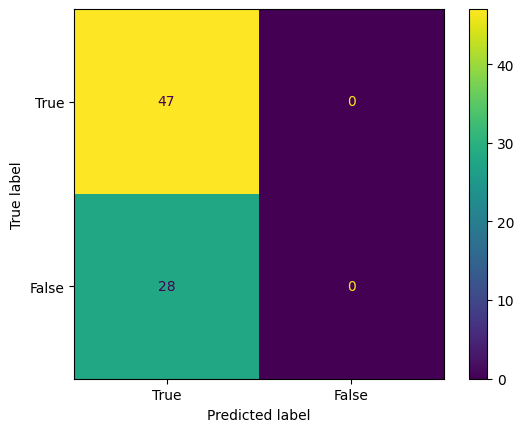

The accuracy of the model is 0.63


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
confusion_matrix = metrics.confusion_matrix(y_val, y_pred_2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])
cm_display.plot()
plt.show()
print(f'The accuracy of the model is {round(accuracy_score(y_val,y_pred_2),2)}')

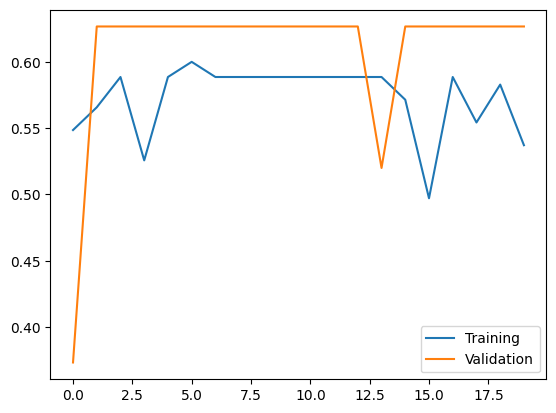

In [ ]:
plt.plot(lstm_res.history['accuracy'], label='Training')
plt.plot(lstm_res.history['val_accuracy'], label='Validation')
plt.legend()

# Fine tune with Kears Tunner

In [ ]:
def build_model(hp):
    inputs = keras.Input(shape=(2422, 8))
    x = layers.BatchNormalization()(inputs)
    x = layers.LSTM(units=hp.Int('lstm_units', min_value=64, max_value=512, step=32))(x)
    x = layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5, # The number of models to try
    executions_per_trial=3, # The number of times each model will be trained to reduce noise
    directory='my_dir4',
    project_name='lstm_tuning')

In [ ]:
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val),
             batch_size=32)

Trial 5 Complete [00h 00m 25s]
val_accuracy: 0.6266666650772095

Best val_accuracy So Far: 0.6311111052831014
Total elapsed time: 00h 03m 08s


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0] # get best parameters
best_model = tuner.hypermodel.build(best_hyperparameters) # build the model

In [ ]:
best_lstm_units = best_hyperparameters.get('lstm_units')
best_dropout_rate = best_hyperparameters.get('dropout_rate')
best_learning_rate = best_hyperparameters.get('learning_rate')

print(f"Best LSTM units: {best_lstm_units}")
print(f"Best dropout rate: {best_dropout_rate}")
print(f"Best learning rate: {best_learning_rate}")

Best LSTM units: 224
Best dropout rate: 0.4
Best learning rate: 0.01


In [ ]:
best_res = best_model.fit(X_train, y_train, epochs=50,validation_data = (X_val,y_val))

Epoch 1/50
6/6 [==============================] - 3s 234ms/step - loss: 0.7952 - accuracy: 0.5314 - val_loss: 0.8280 - val_accuracy: 0.5333
Epoch 2/50
6/6 [==============================] - 1s 117ms/step - loss: 0.7188 - accuracy: 0.5657 - val_loss: 0.7315 - val_accuracy: 0.3733
Epoch 3/50
6/6 [==============================] - 1s 117ms/step - loss: 0.6831 - accuracy: 0.5657 - val_loss: 0.6608 - val_accuracy: 0.6267
Epoch 4/50
6/6 [==============================] - 1s 117ms/step - loss: 0.6739 - accuracy: 0.6114 - val_loss: 0.6685 - val_accuracy: 0.6267
Epoch 5/50
6/6 [==============================] - 1s 116ms/step - loss: 0.6683 - accuracy: 0.5486 - val_loss: 0.6644 - val_accuracy: 0.6267
Epoch 6/50
6/6 [==============================] - 1s 116ms/step - loss: 0.6765 - accuracy: 0.5829 - val_loss: 0.7182 - val_accuracy: 0.3733
Epoch 7/50
6/6 [==============================] - 1s 116ms/step - loss: 0.7362 - accuracy: 0.4971 - val_loss: 0.6609 - val_accuracy: 0.6267
Epoch 8/50
6/6 [====

In [ ]:
y_pred = best_model.predict(X_val)

3/3 [==============================] - 0s 71ms/step


In [ ]:
y_pred = (y_pred > 0.5).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[47,  0],
       [28,  0]])

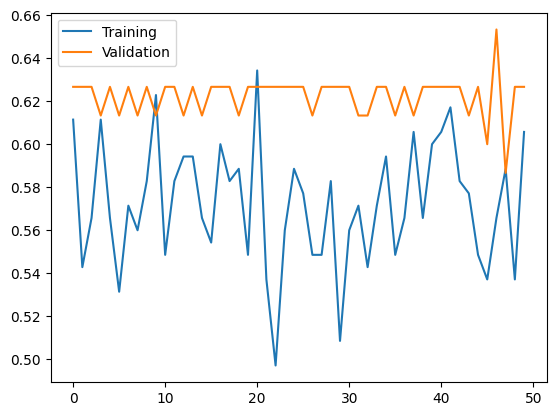

In [ ]:
plt.plot(best_res.history['accuracy'], label='Training')
plt.plot(best_res.history['val_accuracy'], label='Validation')
plt.legend()

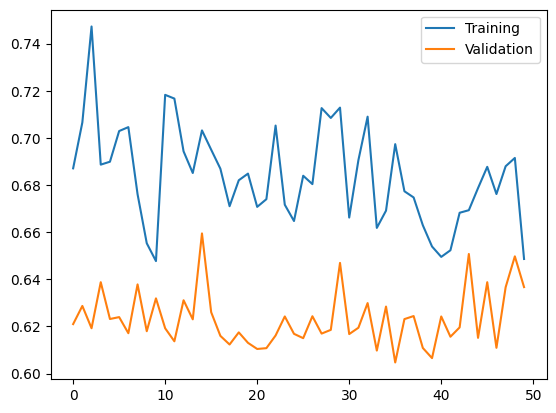

In [ ]:
plt.plot(best_res.history['loss'], label='Training')
plt.plot(best_res.history['val_loss'], label='Validation')
plt.legend()

# RNN Model

In [ ]:
indices = np.arange(len(X_np))
np.random.seed(166)
np.random.shuffle(indices)
shuffled_X_np = X_np[indices]
shuffled_y_np = y_np[indices]
train_size = int(0.7*len(shuffled_X_np))
X_train = shuffled_X_np[:train_size]
X_val = shuffled_X_np[train_size:]
y_train = shuffled_y_np[:train_size]
y_val = shuffled_y_np[train_size:]

In [ ]:
inputs = keras.Input(shape=(2422,8))
x = layers.SimpleRNN(units =64)(inputs)
outputs = layers.Dense(units=1, activation='sigmoid')(x)
RNN_model = keras.Model(inputs =inputs, outputs =outputs)
RNN_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2422, 8)]         0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                4672      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
RNN_model.compile(optimizer ='adam',
                  loss= 'binary_crossentropy',
                  metrics = ['accuracy'])
RNN_model_res = RNN_model.fit(x=X_train,y=y_train, epochs =20,
                              validation_data=(X_val,y_val))

Epoch 1/20
6/6 [==============================] - 7s 983ms/step - loss: 0.6881 - accuracy: 0.5314 - val_loss: 0.7261 - val_accuracy: 0.4533
Epoch 2/20
6/6 [==============================] - 6s 932ms/step - loss: 0.6714 - accuracy: 0.5657 - val_loss: 0.7101 - val_accuracy: 0.4667
Epoch 3/20
6/6 [==============================] - 5s 934ms/step - loss: 0.6898 - accuracy: 0.4743 - val_loss: 0.6624 - val_accuracy: 0.6667
Epoch 4/20
6/6 [==============================] - 6s 951ms/step - loss: 0.7014 - accuracy: 0.5029 - val_loss: 0.6313 - val_accuracy: 0.6667
Epoch 5/20
6/6 [==============================] - 5s 869ms/step - loss: 0.6799 - accuracy: 0.5657 - val_loss: 0.6554 - val_accuracy: 0.6667
Epoch 6/20
6/6 [==============================] - 6s 959ms/step - loss: 0.6768 - accuracy: 0.5657 - val_loss: 0.6725 - val_accuracy: 0.6667
Epoch 7/20
6/6 [==============================] - 5s 886ms/step - loss: 0.6741 - accuracy: 0.5771 - val_loss: 0.6643 - val_accuracy: 0.6267
Epoch 8/20
6/6 [====

In [ ]:
y_pred = RNN_model.predict(X_val)
y_pred_2 = [0 if i < 0.5 else 1 for i in y_pred]

3/3 [==============================] - 1s 145ms/step


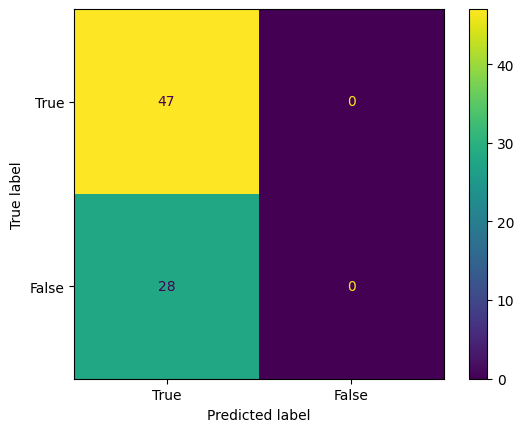

The accuracy of the model is 0.63


In [ ]:
confusion_matrix = metrics.confusion_matrix(y_val, y_pred_2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])
cm_display.plot()
plt.show()
print(f'The accuracy of the model is {round(accuracy_score(y_val,y_pred_2),2)}')

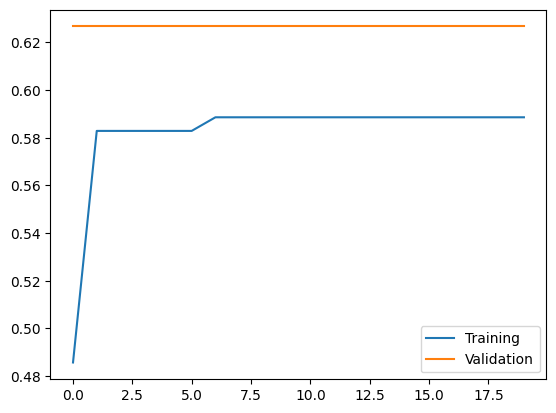

In [ ]:
plt.plot(RNN_model_res.history['accuracy'], label='Training')
plt.plot(RNN_model_res.history['val_accuracy'], label='Validation')
plt.legend()

# Possible Reasons for not improving accuracy

(array([28., 36., 26., 27., 31., 25., 26., 28., 14.,  9.]),
 array([  24. ,  263.8,  503.6,  743.4,  983.2, 1223. , 1462.8, 1702.6,
        1942.4, 2182.2, 2422. ]),
 <BarContainer object of 10 artists>)

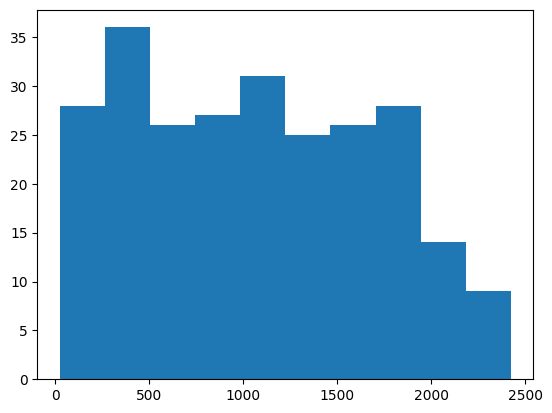

In [ ]:
plt.hist(norm_target_df.PlayerKey.value_counts(), bins= 10)

The majority of the player's total number of plays is around 1000 plays, so by padding them to meet the maximam plays(2422) would be too much

In [ ]:
test = injury_df.groupby('PlayerKey').count().reset_index()

In [ ]:
duplicate_player_keys = test[test['PlayerKey'].duplicated(keep=False)]
print(duplicate_player_keys)

Empty DataFrame
Columns: [PlayerKey, GameID, PlayKey, BodyPart, Surface, DM_M1, DM_M7, DM_M28, DM_M42]
Index: []


In [ ]:
injured_players = pd.merge(play_df, test, on='PlayerKey', how='right')

In [ ]:
healthy_players = pd.merge(play_df, test, on='PlayerKey', how='left',indicator = True)

In [ ]:
healthy_players = healthy_players[healthy_players['_merge'] == 'left_only']
healthy_players = healthy_players.drop(columns=['_merge'])

(array([ 5.,  8., 11., 10.,  5.,  5.,  8.,  5., 10.,  9.,  7., 11.,  7.,
        11., 11.,  9.,  5.,  6.,  4.,  3.]),
 array([  40. ,  159.1,  278.2,  397.3,  516.4,  635.5,  754.6,  873.7,
         992.8, 1111.9, 1231. , 1350.1, 1469.2, 1588.3, 1707.4, 1826.5,
        1945.6, 2064.7, 2183.8, 2302.9, 2422. ]),
 <BarContainer object of 20 artists>)

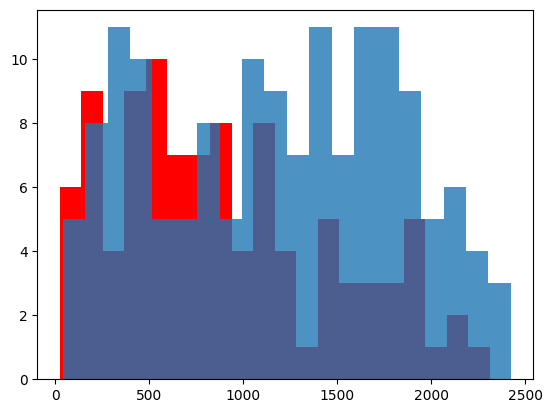

In [ ]:
plt.hist(injured_players.groupby('PlayerKey').count().GameID_x.values,color = 'red',bins =20)
plt.hist(healthy_players.groupby('PlayerKey').count().PlayerDay.values,alpha = 0.8,bins =20)

In [ ]:
print(injured_players.groupby('PlayerKey').count().GameID_x.values.mean())
print(healthy_players.groupby('PlayerKey').count().PlayerDay.values.mean())

897.49
1181.7066666666667


In [ ]:
6800*7.155

48654.0